In [21]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

from hmg import HBV1D012A


In [ ]:
def NSE(sim_dis, obs_dis):
    # obs are the "true" values, sim is our model output
    mean_obs_dis = np.mean(obs_dis)
    return 1 - (np.sum([(obs_dis[i] - sim_dis[i])**2 for i in range(len(sim_dis))])) / (np.sum([(obs_dis[i] - mean_obs_dis)**2 for i in range(len(sim_dis))]))

def LnNSE(sim_dis, obs_dis):
    raise ValueError("Not implemented yet")

def KGE(sim_dis, obs_dis):
    raise ValueError("Not implemented yet")


def objective_function(prms, diso, modl_objt, efficieny_metric, parameter_in_optimization, obj_values):

    allowed_metrics = {NSE, LnNSE, KGE}
    if efficieny_metric not in allowed_metrics:
        raise ValueError(f"efficieny_metric must be one of {allowed_metrics}")

    modl_objt.set_parameters(prms)
    modl_objt.set_optimization_flag(0)

    # Run the model for the given inputs, constants and parameters.
    modl_objt.run_model()
    diss = modl_objt.get_discharge()

    # NSE calculation
    efficiency_value = efficieny_metric(sim_dis=diss, obs_dis=diso)
    # print(f"NSE: {NSE_value}")

    OBJ_value = 1 - efficiency_value
    # print(f"OBJ: {OBJ_value}")

    parameter_in_optimization.append(prms.copy())
    obj_values.append(OBJ_value)
    return OBJ_value

def setup_object_with_data():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    cca_srs = pd.read_csv(r'area___24163005.csv', sep=';', index_col=0)
    ccaa = cca_srs.values[0, 0]
    tems = inp_dfe.loc[:, 'tavg__ref'].values  # Temperature.
    ppts = inp_dfe.loc[:, 'pptn__ref'].values  # Preciptiation.
    pets = inp_dfe.loc[:, 'petn__ref'].values  # PET.
    modl_objt = HBV1D012A()
    tsps = tems.shape[0]  # Number of time steps.
    dslr = ccaa / (3600 * 1000)  # For daily res. multiply denominator with 24.
    modl_objt.set_inputs(tems, ppts, pets)
    modl_objt.set_outputs(tsps)
    modl_objt.set_discharge_scaler(dslr)
    return modl_objt

def get_diso():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    diso = inp_dfe.loc[:, 'diso__ref'].values  # Observed discharge.
    return diso

In [ ]:
bounds = {
    'snw_dth': (0.0, 0.0), #! on if upper bound 100
    'snw_ast': (-1.0, 1.0), #! off if -999
    'snw_amt': (0.0, 2.0), #! off if -99
    'snw_amf': (0.0, 2.0), #! off if 0
    'snw_pmf': (0.0, 2.0), #! off if 0

    'sl0_mse': (0.0, 1e+2),
    'sl1_mse': (0.0, 2e+2),

    # Soil 0 (upper soil)
    'sl0_fcy': (0.0, 2e+2), #! off if 0
    'sl0_bt0': (0.0, 3.0), #! off if 0

    # Soil 1 (lower soil)
    'sl1_pwp': (0.0, 4e+2), #! if Soil 0 off Soil 1 has to be off as well
    'sl1_fcy': (0.0, 4e+2),
    'sl1_bt0': (0.0, 4.0),

    'urr_dth': (0.0, 2e+1),
    'lrr_dth': (0.0, 5.0),

    # Upper reservoir
    'urr_rsr': (0.0, 1.0),
    'urr_tdh': (0.0, 1e+2),
    'urr_tdr': (0.0, 1.0),
    'urr_cst': (0.0, 1.0),
    'urr_dro': (0.0, 1.0),
    'urr_ulc': (0.0, 1.0),

    # Lower reservoir
    'lrr_tdh': (0.0, 1e+4),
    'lrr_cst': (0.0, 1.0),
    'lrr_dro': (0.0, 1.0)
}


prms = np.array([
    0.00,  # 'snw_dth'
    -0.1,  # 'snw_ast'
    +0.1,  # 'snw_amt'
    0.01,  # 'snw_amf'
    0.00,  # 'snw_pmf'

    50.0,  # 'sl0_mse'
    300.,  # 'sl1_mse'

    70.0,  # 'sl0_fcy'
    2.50,  # 'sl0_bt0'

    300.,  # 'sl1_pwp'
    400.,  # 'sl1_fcy'
    2.50,  # 'sl1_bt0'

    0.00,  # 'urr_dth'
    0.00,  # 'lrr_dth'

    1.00,  # 'urr_rsr'
    30.0,  # 'urr_tdh'
    0.15,  # 'urr_tdr'
    1e-4,  # 'urr_cst'
    1.00,  # 'urr_dro'
    0.00,  # 'urr_ulc'

    0.00,  # 'lrr_tdh'
    0.00,  # 'lrr_cst'
    0.00,  # 'lrr_dro'
    ], dtype=np.float32)

In [24]:
diso = get_diso()
modl_objt = setup_object_with_data()
#! objective_function(prms, diso, modl_objt, NSE, parameter_in_optimization, obj_values)

In [ ]:
parameter_in_optimization = []
obj_values = []

result = differential_evolution(objective_function, list(bounds.values()), polish=False, args=(diso, modl_objt, NSE, parameter_in_optimization, obj_values))

parameter_in_optimization = np.array(parameter_in_optimization)
obj_values = np.array(obj_values)

print(f"result.x: {result.x}")
print(f"result.fun: {result.fun}")

opt_prms = result.x

Model runtime: 2.15E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.02E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 1.95E-02 seconds.
Model runtime: 1.84E-02 seconds.
Model runtime: 1.89E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.01E-02 seconds.
Model runtime: 2.02E-02 seconds.
Model runtime: 2.14E-02 seconds.
Model runtime: 1.96E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.11E-02 seconds.
Model runtime: 1.91E-02 seconds.
Model runtime: 2.00E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.03E-02 seconds.
Model runtime: 2.04E-02 seconds.
Model runtime: 2.02E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 2.01E-02 seconds.
Model runtime: 2.09E-02 seconds.
Model runtime: 2.06E-02 seconds.
Model runtime: 2.01E-02 seconds.
Model runtime: 2.01E-02 seconds.
Model runt

In [26]:
# result from above
opt_prms = np.array([0.00000000e+00, # 'snw_dth'
            -8.50456759e-01, # 'snw_ast'
            1.55656933e+00, # 'snw_amt'
            0.00000000e+00, # 'snw_amf'
            1.23171246e+00, # 'snw_pmf'

            7.28789541e+01, # 'sl0_mse'
            1.84629921e+02, # 'sl1_mse'

            1.44196315e+02, # 'sl0_fcy'
            2.15978555e+00, # 'sl0_bt0'

            1.56338210e+02, # 'sl1_pwp'
            7.51584389e+01, # 'sl1_fcy'
            8.02963602e-01, # 'sl1_bt0'

            2.42125374e+00, # 'urr_dth'
            0.00000000e+00, # 'lrr_dth'

            9.34173302e-01, # 'urr_rsr'
            3.00000000e+05, # 'urr_tdh'
            0.00000000e+00, # 'urr_tdr'
            0.00000000e+00, # 'urr_cst'
            0.00000000e+00, # 'urr_dro'
            9.37866241e-03, # 'urr_ulc'

            6.71475300e+02, # 'lrr_tdh'
            1.66273918e-01, # 'lrr_cst'
            9.97923827e-01 # 'lrr_dro'
            ], dtype=np.float32)

In [ ]:
diso = get_diso()
modl_objt = setup_object_with_data()
#!objective_function(opt_prms, diso, modl_objt, NSE)

TypeError: objective_function() missing 2 required positional arguments: 'parameter_in_optimization' and 'obj_values'

In [28]:
# Function to vary one of the parameters in the bounds and fix the rest to the optimal values
def vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size):
    opt_prms_copy = opt_prms.copy()
    param_index = list(bounds.keys()).index(param_name)
    param_values = np.linspace(bounds[param_name][0], bounds[param_name][1], sample_size)
    obj_func_values = []
    for param_value in param_values:
        opt_prms_copy[param_index] = param_value
        obj_func_values.append(objective_function(opt_prms_copy, diso, modl_objt, NSE))
    return param_values, obj_func_values

In [29]:
def plot_variation_task(param_name, bounds, opt_prms, diso, modl_objt, sample_size):
    param_values, obj_func_values = vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size)
    param_value_opt = opt_prms[list(bounds.keys()).index(param_name)]
    obj_func_value_opt = objective_function(opt_prms, diso, modl_objt, NSE)
    plt.scatter(param_value_opt, obj_func_value_opt, color='red', zorder=5)
    plt.plot(param_values, obj_func_values)
    plt.xlabel(param_name)
    plt.legend(['Optimal value', 'Objective function'])
    plt.ylabel('Objective function value')
    plt.title(f'Objective function value vs {param_name}')
    plt.show()

Model runtime: 1.88E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.89E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.90E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.85E-02 seconds.
Model runtime: 1.85E-02 seconds.
Model runtime: 1.85E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.85E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.86E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runt

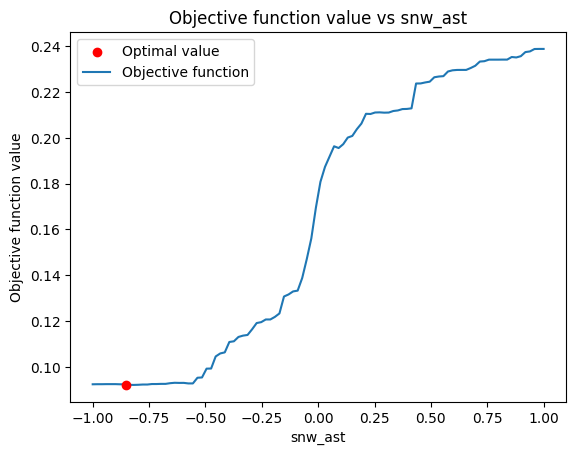

In [ ]:
# Call paramter variation for snw_ast and plot the results
param_name = 'snw_ast'
sample_size = 100

plot_variation_task(param_name, bounds, opt_prms, diso, modl_objt, sample_size)

55110


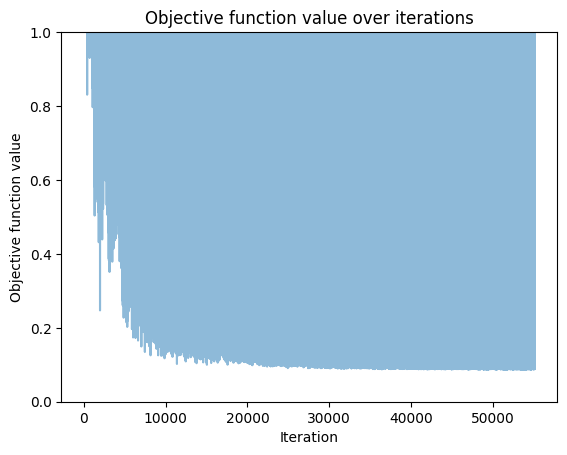

In [ ]:
print(len(parameter_in_optimization))

#! obj_values = []

param_index = list(bounds.keys()).index(param_name)

# Plot the obj_values
plt.plot(obj_values, alpha=0.5) #! use logarithmic scale
#! add best value as running minimum
plt.ylim(0, 1)
plt.xlabel('Iteration')
plt.ylabel('Objective function value')
plt.title('Objective function value over iterations')
plt.show()

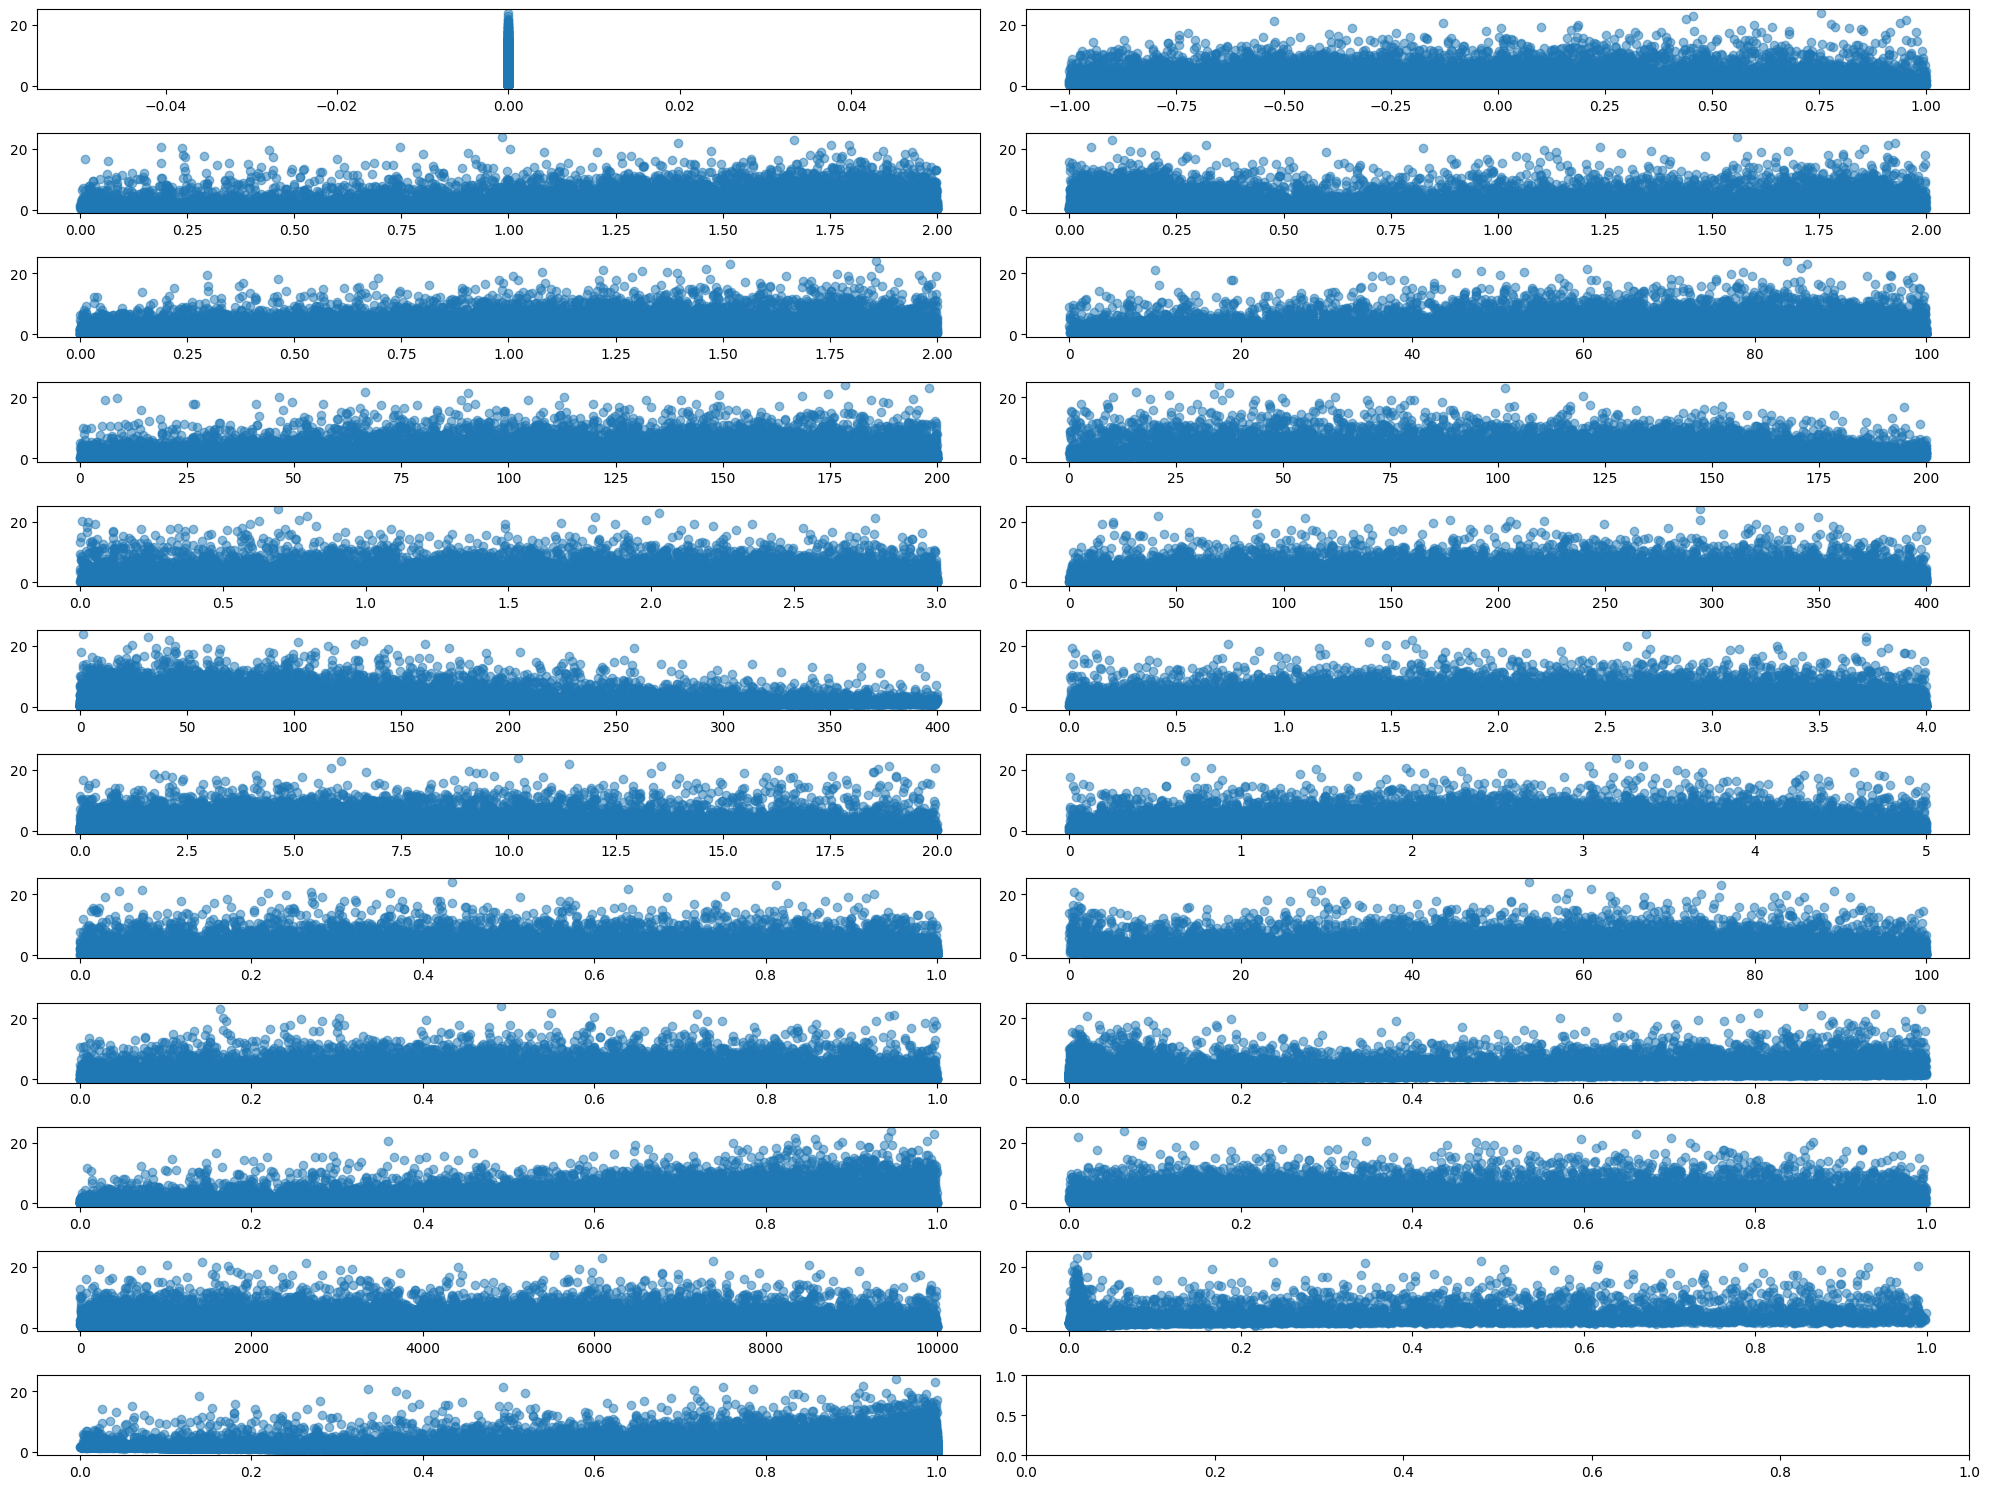

In [ ]:
# Plot parameter by name (x) and obj-function values (y)
fig, axs = plt.subplots(12, 2, figsize=(20, 15))
for index, param_name in enumerate(bounds.keys()):
    param_index = list(bounds.keys()).index(param_name)
    axs[index // 2, index % 2].scatter(parameter_in_optimization[:, param_index], obj_values, alpha=0.5)

plt.tight_layout()
plt.show()

Model runtime: 2.03E-02 seconds.


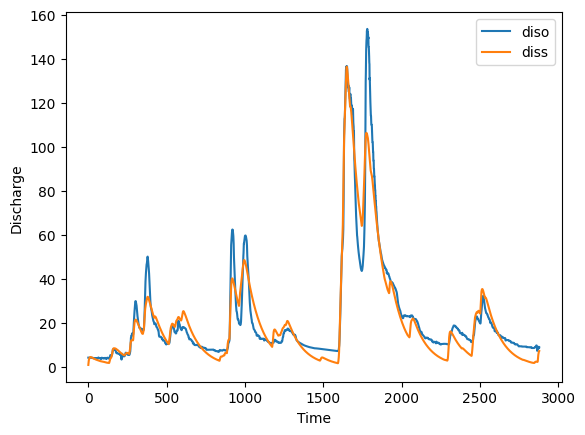

In [44]:
plt.plot(diso, label="diso")


modl_objt.set_parameters(result.x)
modl_objt.set_optimization_flag(0)

# Run the model for the given inputs, constants and parameters.
modl_objt.run_model()
diss = modl_objt.get_discharge()

plt.plot(diss, label="diss")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Discharge')

plt.show()

In [ ]:
# Notes for processes turned off and on:

# look at slides in lecture for different modules
# plot best case against each case
# 6 different cases
